# Proceso de discretización 

Para este punto es necesario contar con el archivo .tif obtenido del corte realizado en el paso 1

In [1]:
import rasterio as rio
from rasterio.mask import mask
import shapefile
from osgeo import gdal, gdalnumeric, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import os

Plot del archivo

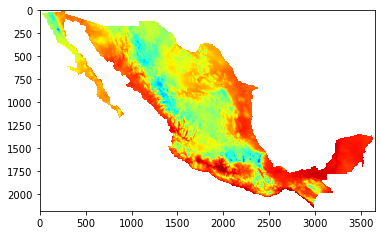

In [2]:
mex = 'mex_bioc_CNRM-CM6-1_ssp245_2021-2040.tif'
src = rio.open(mex)
plt.imshow(src.read(1), cmap='jet')
plt.show()

Recordar del paso 1 que este raster cuenta con 19 capas, una por cada variable bioclimática

In [3]:
layer = gdal.Open(mex)

raster_info = {
                'xsize': layer.RasterXSize,
                'ysize': layer.RasterYSize,
                'geo_transformation': layer.GetGeoTransform(),
                'projection': layer.GetProjection()
              }

data = layer.ReadAsArray()

raster_info

{'xsize': 3648,
 'ysize': 2183,
 'geo_transformation': (-117.1333333333333,
  0.008333333333333338,
  0.0,
  32.724999999999966,
  0.0,
  -0.008333333333333338),
 'projection': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

Ahora que los datos se encuentran en el array llamado data, se imprimen los rangos de cada variable bioclimática. Además se crea la variable data_dict donde las llaves son las abreviaciones de las descripciones y sus valores son los array de data




In [4]:
#Con las descripciones extraidas de worlclim verificamos el rango de los 19 layers
descriptions = ['Annual Mean Temperature', 
                'Mean Diurnal Range (Mean of monthly (max temp - min temp))', 
                'Isothermality (BIO2/BIO7) (×100)', 
                'Temperature Seasonality (standard deviation ×100)', 
                'Max Temperature of Warmest Month', 
                'Min Temperature of Coldest Month', 
                'Temperature Annual Range (BIO5-BIO6)', 
                'Mean Temperature of Wettest Quarter', 
                'Mean Temperature of Driest Quarter', 
                'Mean Temperature of Warmest Quarter', 
                'Mean Temperature of Coldest Quarter', 
                'Annual Precipitation', 
                'Precipitation of Wettest Month', 
                'Precipitation of Driest Month', 
                'Precipitation Seasonality (Coefficient of Variation)', 
                'Precipitation of Wettest Quarter', 
                'Precipitation of Driest Quarter', 
                'Precipitation of Warmest Quarter', 
                'Precipitation of Coldest Quarter']
desc_abb= ['AMT', 'MDR', 'ISO', 'TS', 'MTWM', 'MTCM', '(BIO5-BIO6)', 'MTWettQ', 'MDQ', 'MTWarmQ', 'MTCQ', 'AP', 'PWM', 'PDM', 'PSCV', 'PWettQ', 'PDQ', 'PWarmQ', 'PCQ']
desc_dict ={}
abb_dict=[]
for i in range(19):
    desc_dict[descriptions[i]] = desc_abb[i]
    abb_dict.append(desc_abb[i])

for i in range (0,19):
    print([np.nanmin(data[i]),np.nanmax(data[i])], descriptions[i], "||| ", desc_abb[i])

[3.4, 30.0] Annual Mean Temperature |||  AMT
[6.4, 21.1] Mean Diurnal Range (Mean of monthly (max temp - min temp)) |||  MDR
[31.2, 87.8] Isothermality (BIO2/BIO7) (×100) |||  ISO
[36.3, 857.7] Temperature Seasonality (standard deviation ×100) |||  TS
[10.6, 45.0] Max Temperature of Warmest Month |||  MTWM
[-4.8, 23.4] Min Temperature of Coldest Month |||  MTCM
[9.4, 40.6] Temperature Annual Range (BIO5-BIO6) |||  (BIO5-BIO6)
[3.2, 34.2] Mean Temperature of Wettest Quarter |||  MTWettQ
[2.5, 31.4] Mean Temperature of Driest Quarter |||  MDQ
[4.0, 35.2] Mean Temperature of Warmest Quarter |||  MTWarmQ
[2.7, 28.9] Mean Temperature of Coldest Quarter |||  MTCQ
[44.0, 4880.0] Annual Precipitation |||  AP
[9.0, 870.0] Precipitation of Wettest Month |||  PWM
[0.0, 169.0] Precipitation of Driest Month |||  PDM
[38.8, 149.0] Precipitation Seasonality (Coefficient of Variation) |||  PSCV
[20.0, 2519.0] Precipitation of Wettest Quarter |||  PWettQ
[0.0, 607.0] Precipitation of Driest Quarter |||

Ahora hay que obtener los percentiles de cada variable bioclimática. Se debe tomar en consideración que al considerar proyecciones de futuro se respetan los percentiles de worldclim que ya existían.

Estos percentiles se obtienen de la API de EPI-PUMA

In [5]:
import requests
import json

#Obtenemos los intervalos de cada label

url = "https://covid19.c3.unam.mx/gateway/api/nodes/"
headers = {'Content-type': 'application/json'}

query = []
responses=[]
for i in range(19):
    query.append("{all_worldclim_covariables(limit: 1000, filter: \"label='"+ descriptions[i] +"'\"){interval}}")

for i in range(19):
    dt = json.dumps({'query': query[i]})
    requests.post(url, headers=headers, data=dt)
    responses.append(requests.post(url, headers=headers, data=dt).json()['data']['all_worldclim_covariables'])

In [6]:
responses


[[{'interval': '2.050:13.525'},
  {'interval': '13.525:15.225'},
  {'interval': '15.225:16.146'},
  {'interval': '16.146:16.737'},
  {'interval': '16.737:17.225'},
  {'interval': '17.225:17.846'},
  {'interval': '17.846:18.517'},
  {'interval': '18.517:19.183'},
  {'interval': '19.183:19.867'},
  {'interval': '19.867:20.517'},
  {'interval': '20.517:21.092'},
  {'interval': '21.092:21.700'},
  {'interval': '21.700:22.342'},
  {'interval': '22.342:23.033'},
  {'interval': '23.033:23.650'},
  {'interval': '23.650:24.408'},
  {'interval': '25.096:25.675'},
  {'interval': '26.204:28.754'},
  {'interval': '24.408:25.096'},
  {'interval': '25.675:26.204'}],
 [{'interval': '6.275:10.608'},
  {'interval': '10.608:11.550'},
  {'interval': '11.550:12.375'},
  {'interval': '12.375:12.992'},
  {'interval': '12.992:13.517'},
  {'interval': '13.517:13.950'},
  {'interval': '13.950:14.400'},
  {'interval': '14.400:14.867'},
  {'interval': '14.867:15.317'},
  {'interval': '15.317:15.742'},
  {'interva

In [7]:
#Cada respuesta contiene los intervalos, ahora hay que obtener los percentiles y etiquetarlos con las abreviaciones  
percentiles={}

for i in range(19):
    percentiles[desc_abb[i]]=[]    

for i in range(19):
    for json_obj in responses[i]:
        interval_str = json_obj['interval']
        first_number = interval_str.split(':')[0]
        percentiles[desc_abb[i]].append(float(first_number))

for key in percentiles:
        percentiles[key].sort()



In [8]:
percentiles


{'AMT': [2.05,
  13.525,
  15.225,
  16.146,
  16.737,
  17.225,
  17.846,
  18.517,
  19.183,
  19.867,
  20.517,
  21.092,
  21.7,
  22.342,
  23.033,
  23.65,
  24.408,
  25.096,
  25.675,
  26.204],
 'MDR': [6.275,
  10.608,
  11.55,
  12.375,
  12.992,
  13.517,
  13.95,
  14.4,
  14.867,
  15.317,
  15.742,
  16.133,
  16.483,
  16.808,
  17.108,
  17.4,
  17.692,
  17.983,
  18.325,
  18.792],
 'ISO': [31.622,
  47.281,
  49.119,
  50.439,
  51.685,
  53.088,
  54.336,
  55.527,
  56.723,
  58.212,
  60.063,
  61.706,
  62.741,
  63.617,
  64.468,
  65.417,
  66.816,
  68.388,
  70.244,
  72.151],
 'TS': [37.262,
  133.315,
  163.797,
  182.257,
  199.982,
  216.044,
  238.883,
  268.899,
  297.121,
  328.932,
  365.757,
  399.669,
  445.561,
  487.604,
  520.718,
  548.732,
  578.656,
  611.223,
  645.559,
  695.846],
 'MTWM': [9.4,
  26.0,
  28.1,
  29.3,
  30.1,
  30.9,
  31.6,
  32.3,
  32.9,
  33.4,
  33.9,
  34.3,
  34.7,
  35.1,
  35.5,
  35.8,
  36.2,
  36.6,
  37.4,
  3

Se guardan las matrices en un diccionario donde las llaves son las abreviaciones de las variables bioclimáticas

In [9]:
data_dict = {desc_abb[i]: data[i] for i in range(len(desc_abb))}
data_dict

{'AMT': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'MDR': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'ISO': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 'TS': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

Debido a que las predicciones pueden disminuir o aumentar los valores de los rangos, es necesario cambiar la cota inferior y la cota superior en cada percentil

In [10]:
for key in percentiles:
    arr = percentiles[key]
    arr.append(np.nanmax(data_dict[key])+1)  #Se aumenta la cota superior
    if np.nanmin(data_dict[key])< arr[0]:    #Se cambia la cota inferior de ser necesario 
        arr[0] = np.nanmin(data_dict[key])       

In [11]:
percentiles

{'AMT': [2.05,
  13.525,
  15.225,
  16.146,
  16.737,
  17.225,
  17.846,
  18.517,
  19.183,
  19.867,
  20.517,
  21.092,
  21.7,
  22.342,
  23.033,
  23.65,
  24.408,
  25.096,
  25.675,
  26.204,
  31.0],
 'MDR': [6.275,
  10.608,
  11.55,
  12.375,
  12.992,
  13.517,
  13.95,
  14.4,
  14.867,
  15.317,
  15.742,
  16.133,
  16.483,
  16.808,
  17.108,
  17.4,
  17.692,
  17.983,
  18.325,
  18.792,
  22.100000381469727],
 'ISO': [31.2,
  47.281,
  49.119,
  50.439,
  51.685,
  53.088,
  54.336,
  55.527,
  56.723,
  58.212,
  60.063,
  61.706,
  62.741,
  63.617,
  64.468,
  65.417,
  66.816,
  68.388,
  70.244,
  72.151,
  88.80000305175781],
 'TS': [36.3,
  133.315,
  163.797,
  182.257,
  199.982,
  216.044,
  238.883,
  268.899,
  297.121,
  328.932,
  365.757,
  399.669,
  445.561,
  487.604,
  520.718,
  548.732,
  578.656,
  611.223,
  645.559,
  695.846,
  858.7000122070312],
 'MTWM': [9.4,
  26.0,
  28.1,
  29.3,
  30.1,
  30.9,
  31.6,
  32.3,
  32.9,
  33.4,
  33.9,

# Máscara


Para poder hacer la máscara se reemplaza los valores nan por uno fuera de todos los rango

In [12]:
data= np.nan_to_num(data, nan=-3.4e+38) 

data_dict = {desc_abb[i]: data[i] for i in range(len(desc_abb))}
data_dict

{'AMT': array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        ...,
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
       dtype=float32),
 'MDR': array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        ...,
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
        [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
       dtype=float32),
 'ISO': arra

In [13]:
for key in data_dict:
    data_dict[key] = np.ma.masked_less(data_dict[key], value=-3e+38)


In [14]:
data_dict

{'AMT': masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=1e+20,
   dtype=float32),
 'MDR': masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True, 

In [15]:
for key in data_dict:
    print(data_dict[key].filled(2*percentiles[key][-1]))

[[62. 62. 62. ... 62. 62. 62.]
 [62. 62. 62. ... 62. 62. 62.]
 [62. 62. 62. ... 62. 62. 62.]
 ...
 [62. 62. 62. ... 62. 62. 62.]
 [62. 62. 62. ... 62. 62. 62.]
 [62. 62. 62. ... 62. 62. 62.]]
[[44.2 44.2 44.2 ... 44.2 44.2 44.2]
 [44.2 44.2 44.2 ... 44.2 44.2 44.2]
 [44.2 44.2 44.2 ... 44.2 44.2 44.2]
 ...
 [44.2 44.2 44.2 ... 44.2 44.2 44.2]
 [44.2 44.2 44.2 ... 44.2 44.2 44.2]
 [44.2 44.2 44.2 ... 44.2 44.2 44.2]]
[[177.6 177.6 177.6 ... 177.6 177.6 177.6]
 [177.6 177.6 177.6 ... 177.6 177.6 177.6]
 [177.6 177.6 177.6 ... 177.6 177.6 177.6]
 ...
 [177.6 177.6 177.6 ... 177.6 177.6 177.6]
 [177.6 177.6 177.6 ... 177.6 177.6 177.6]
 [177.6 177.6 177.6 ... 177.6 177.6 177.6]]
[[1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]
 [1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]
 [1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]
 ...
 [1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]
 [1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]
 [1717.4 1717.4 1717.4 ... 1717.4 1717.4 1717.4]]
[[92. 92. 92. ..

#    Reclasificación

Ahora creamos un diccionario a partir de data_dict donde se cambia el valor de la coordenada por el percentil en que el valor se encuentra

In [16]:
reclass = {}
for key in data_dict:
    reclass[key]= np.searchsorted(percentiles[key][1:], data_dict[key].filled(2*percentiles[key][-1]))

In [17]:
reclass

{'AMT': array([[20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        ...,
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20]], dtype=int64),
 'MDR': array([[20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        ...,
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20]], dtype=int64),
 'ISO': array([[20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        ...,
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20]], dtype=int64),
 'TS': array([[20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 20, ..., 20, 20, 20],
        ...,
        [20, 20, 20, ..., 20, 20, 20],
        [20, 20, 2

In [18]:
for key in data_dict:
    print(np.unique(reclass[key], return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64), array([  49852,   88783,   59994,   51962,   57207,   95215,  158387,
        138356,  135770,  129283,   96726,  107938,  138177,  162540,
        122700,  141138,  121366,  121416,  114189,  399927, 5472658],
      dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64), array([ 130623,  116825,  122590,  119074,  136934,  106231,  131692,
        104285,  131838,  113455,  122092,   99686,  146936,  115385,
        121693,   82165,  126616,  159639,  124492,  178675, 5472658],
      dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64), array([ 138458,  142156,  132469,  115813,  126243,  137028,  133584,
        108379,  100936,  122148,  145133,  138926,  119999,   99931,
        122242,  110261,  112091,  121543,  122132,  141

In [19]:
for key in percentiles:
    percentiles[key] = np.array(percentiles[key])

for key in reclass:
    reclass[key] += 1
    reclass[key] = np.ma.masked_equal(reclass[key], percentiles[key].shape[0])

In [20]:
reclass

{'AMT': masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=21,
   dtype=int64),
 'MDR': masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True

In [21]:
for key in reclass:
    print(np.unique(reclass[key], return_counts=True))

(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False,  True],
       fill_value=21,
            dtype=int64), array([  49852,   88783,   59994,   51962,   57207,   95215,  158387,
        138356,  135770,  129283,   96726,  107938,  138177,  162540,
        122700,  141138,  121366,  121416,  114189,  399927, 5472658],
      dtype=int64))
(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False,  True],
       fill_value=21,
            dtype=int64), array([ 130623,  116825,  122590,

(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False,  True],
       fill_value=21,
            dtype=int64), array([ 134053,  129454,  127221,  124710,  125745,  125257,  131335,
        136887,  115914,  103946,  103090,  105592,  124838,  123802,
        117988,  118927,  122720,  111013,  107640,  200794, 5472658],
      dtype=int64))
(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False,  True],
       fill_value=21,
            dtype=int64), array([ 126749,  152160,  142443,

In [22]:
np.unique(reclass['AMT'], return_counts=True)

(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19, 20, --],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False,  True],
        fill_value=21,
             dtype=int64),
 array([  49852,   88783,   59994,   51962,   57207,   95215,  158387,
         138356,  135770,  129283,   96726,  107938,  138177,  162540,
         122700,  141138,  121366,  121416,  114189,  399927, 5472658],
       dtype=int64))

Cómo se ve cada la matriz discretizada 

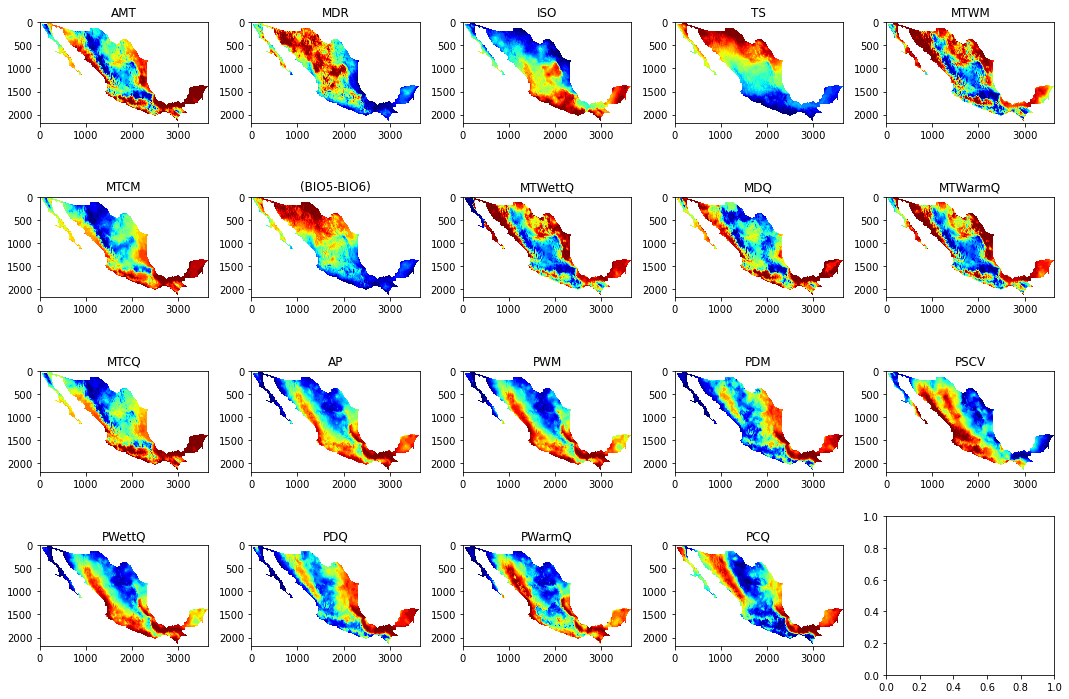

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
axes = axes.flatten()

for i, key in enumerate(reclass.keys()):
    matrix = reclass[key]
    ax = axes[i]
    ax.imshow(matrix, cmap='jet')
    ax.set_title(key)
    
fig.tight_layout()

plt.show()

Ahora guardamos cada matriz en un archivo para poder pasar al siguiente paso

In [24]:
mex = mex.replace('mex_bioc_','')
carpet = mex[:-4]
print(carpet)


def create_raster_from_array(array, file_name):
    rows, cols = array.shape
    driver = gdal.GetDriverByName('GTiff')
    ds = driver.Create(file_name, cols, rows, 1, gdal.GDT_Float32)
    geo_transformation = (-117.1333333333333, 0.008333333333333338, 0.0, 32.724999999999966, 0.0,-0.008333333333333338) 
    ds.SetGeoTransform(geo_transformation)
    nodata = array.fill_value
    array = array.filled()    
    band = ds.GetRasterBand(1)
    band.WriteArray(array)
    band.SetNoDataValue(float(nodata))
    band.FlushCache()
    ds =None


CNRM-CM6-1_ssp245_2021-2040


Finalmente se guarda cada archivo en una carpeta

In [25]:
import shutil
files_names = []
for key in reclass:    
    files_names.append('/'+key+'.tif')
    create_raster_from_array(reclass[key], key + '.tif')
    

In [26]:
def move_files_to_directory(file_names, directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    for file_name in file_names:
        shutil.move(os.getcwd() + file_name , directory_name)
    print('Los archivos se encuentran en ' + os.getcwd()+ '\\'  + directory_name )


In [27]:
carpet = mex[:-4]
move_files_to_directory(files_names, carpet)

Los archivos se encuentran en C:\Users\user\Desktop\Emisiones del futuro\CNRM-CM6-1_ssp245_2021-2040
